<h2>Pipeline Stage 1: Initial Filtering and Logic Scoring</h2>

<p>Welcome to the first stage in the matching pipeline! At the end of the pipeline, each student will have a 1 to 2 strong matches. Each company will have a minimum of 2 strong matches and a maximum of 4 strong matches. This fully automates the manual matching process that was done in the past. Let's get started!</p>

<p>The table I will be using throughout these pipelines is a cross join of the position profiles and student applications. This means that every student is matched with every company for each year of matching. The goal of each stage of the pipeline is to reduce these matches so each student is matched with their most aligned company, and each company gets a pool of quality candidates.</p>

<p><strong>Note:</strong> The data used in this pipeline was generated by AI to ensure confidentiality of the original data. As a result, the outcomes may differ from the actual dataset. However, the findings presented in the Technical White Paper are based on real student and company data, thoroughly anonymized to remove any identifying details.</p>

<h3>Description of the table:</h3>
<ul>
  <li><strong>Student application columns:</strong> Marked with a <code>'stu_'</code> prefix.</li>
  <li><strong>Position profile columns:</strong> Marked with a <code>'pos_'</code> prefix.</li>
  <li><strong>Year columns:</strong> I added a <code>'stu_Year'</code> and <code>'pos_Year'</code> column to the table to filter out students that are not in the same year as the position.</li>
  <li><strong>Unstructured text data:</strong> The main columns used in the pipeline are any unstructured text data. This includes the <code>'stu_Resume Text'</code> and <code>'pos_Job Description text'</code>, and any text field data added when students and companies created their profiles.</li>
</ul>

<p><strong>Note:</strong> This project uses a custom library I created called <code>'utils.py'</code>, found in the <code>'my_package'</code> folder of this project. This library contains functions that are used throughout the pipeline. Make sure to download the library into your Python environment before running this script. This project used python 3.11.9</p>


In [6]:
#~~~
import pandas as pd
from mypackage.utils import *
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import json

In [7]:

# Set the path to the project here. If you run the code, any tables will be loaded automatically.
# The load path will carry over across all notebooks in the project.
path_to_project = '/path/to/project/script_matching_code_anonymized'

# Function to save the path to a JSON file
save_project_path(path_to_project)

Project path saved to project_config.json.


The SP table shown below is a cross-join between the student application table and the position profile table. It has been scored using the original weighted scoring method for matching. The matching scores are located in the "Total Points" and "Total Point Breakup" columns and will be used to compare the results of the original matching pipeline with the AI-based matching pipeline.

In [8]:
path = f'{path_to_project}/data/SP_table/SP1.parquet'
SP = pd.read_parquet(path)

Below is code that mimics the same filtering system we use currently. It filters out students with less then 2 skill matches. 
If you run the code below and look at the results, it highlights one of the main problems with the current system; over and under matching.

In [9]:
# Function to count stu_Z1 + stu_Z2 occurrences
def count_stu_Z1_Z2_skills(total_points_breakup):
    return total_points_breakup.count('stu_Z1') + total_points_breakup.count('stu_Z2')

# Apply the function to count stu_Z2 skills in each row
SP['stu_skill_count'] = SP['Total Points BreakUp'].apply(count_stu_Z1_Z2_skills)

# Filter rows where stu_Z2_count is less than 3
SP_filtered = SP[SP['stu_skill_count'] >= 3]

# Calculate the number of matches for each company
pos_match_counts = SP_filtered['pos_(Do Not Modify) Job Posting'].value_counts().reset_index()
pos_match_counts.columns = ['pos_(Do Not Modify) Job Posting', 'pos_Number of Matches']

# Merge the match counts back into the combined DataFrame
SP_filtered = SP_filtered.merge(pos_match_counts, on='pos_(Do Not Modify) Job Posting', how='left')

# Calculate the number of matches for each student
stu_match_counts = SP_filtered['stu_(Do Not Modify) Application'].value_counts().reset_index()
stu_match_counts.columns = ['stu_(Do Not Modify) Application', 'stu_Number of Matches']

# Merge the student match counts back into the combined DataFrame
SP_filtered = SP_filtered.merge(stu_match_counts, on='stu_(Do Not Modify) Application', how='left')

# Create the 'pos_Difficult to Match' column
SP_filtered['pos_Difficult to Match'] = SP_filtered['pos_Number of Matches'].apply(lambda x: 'Yes' if x < 10 else 'No')

# Drop the temporary stu_Z2_count column
SP_filtered = SP_filtered.drop(columns=['stu_skill_count'])


# Identify job postings that have all their rows filtered out
hard_to_match_companies = SP[~SP['pos_(Do Not Modify) Job Posting'].isin(SP_filtered['pos_(Do Not Modify) Job Posting'].unique())]

# Process 'hmat' DataFrame to retain only pos_ columns and drop duplicates
hmat = hard_to_match_companies.loc[:, hard_to_match_companies.columns.str.startswith('pos_')].drop_duplicates()

print(hmat.shape)

# Add columns to 'hmat' DataFrame
hmat['stu_(Do Not Modify) Application'] = ""
hmat['Total Points'] = ""
hmat['Total Points BreakUp'] = ""

# Combine 'hmat' with the filtered DataFrame
SP_combined = pd.concat([SP_filtered, hmat], ignore_index=True)

# set blank values in 'pos_Number of Matches' to 0
SP_combined['pos_Number of Matches'] = SP_combined['pos_Number of Matches'].fillna(0)

# if the 'stu_(Do Not Modify) Application' is blank, set the 'pos_Number of Matches' to 0
SP_combined.loc[SP_combined['stu_(Do Not Modify) Application'] == '', 'pos_Number of Matches'] = 0

# convert the 'pos_Number of Matches' column to integer type
SP_combined['pos_Number of Matches'] = SP_combined['pos_Number of Matches'].astype(int)

# if the 'stu_(Do Not Modify) Application' is blank, set the 'Total Points' to 0
SP_combined.loc[SP_combined['stu_(Do Not Modify) Application'] == '', 'Total Points'] = 0

# convert the 'Total Points' column to integer type
SP_combined['Total Points'] = SP_combined['Total Points'].astype(int)

# The resulting DataFrame SP_combined now contains the desired columns
SP_filtered = SP_combined

# save the SP_filtered table to a parquet file
SP_filtered_path = f'{path_to_project}/data/SP_table/SP_filtered.parquet'
SP_filtered.to_parquet(SP_filtered_path)


(5, 10)


In [10]:
# The resulting table from this code will show you the number of matches for each position profile after filtering out ineligible students and students with less than 3 skills.

cols = ''' 
pos_Company
pos_Name
pos_(Do Not Modify) Job Posting
pos_Number of Matches
'''
cols = as_list(cols)

pos_num_matches = SP_filtered[cols]

# drop duplicates
pos_num_matches = pos_num_matches.drop_duplicates()

# sort by 'pos_Number of Matches' in descending order
pos_num_matches = pos_num_matches.sort_values(by='pos_Number of Matches', ascending=False)

# Display the table
cols_to_display = ['pos_Company', 'pos_Name', 'pos_Number of Matches']
pretty_print(pos_num_matches[cols_to_display])


+-------+----------------------------------+--------------------------------------------------------------------------+-----------------------+
| Index |           pos_Company            |                                 pos_Name                                 | pos_Number of Matches |
+-------+----------------------------------+--------------------------------------------------------------------------+-----------------------+
|   26  |  Green Initiatives Organization  |                   Marketing and Media Strategy Intern                    |          294          |
|   5   |        Insight Analytics         |                            Research Assistant                            |          276          |
|   4   |           Design Firm            |                           Marketing Internship                           |          274          |
|   20  |         Umbrella Tactics         |                         Digital Marketing Intern                         |          235    

As you can see, several companies have 0 to 2 matches, requiring a manual process of matching students to these companies. This takes a lot of time and effort. The goal of the pipeline is to eliminate this manual process and automate the matching process, providing each company with a pool of quality candidates. Some companies are also clearly overmatched, with more then 200 matches. This makes it difficult to find the best candidates for the positions.


In [11]:
# The resulting table from this code will show you the number of matches for each student application after filtering out ineligible students and students with less than 3 skills.

cols = '''  
stu_(Do Not Modify) Application
stu_Legal Name
stu_Number of Matches
'''

cols = as_list(cols)

stu_num_matches = SP_filtered[cols]

# drop duplicates
stu_num_matches = stu_num_matches.drop_duplicates()

# sort by 'stu_Number of Matches' in descending order
stu_num_matches = stu_num_matches.sort_values(by='stu_Number of Matches', ascending=False)

# drop nan values
stu_num_matches = stu_num_matches.dropna()

cols_to_display = ['stu_Legal Name', 'stu_Number of Matches']
pretty_print(stu_num_matches[cols_to_display])


+-------+---------------------+-----------------------+
| Index |    stu_Legal Name   | stu_Number of Matches |
+-------+---------------------+-----------------------+
|  3985 |     Jordan Smith    |          72.0         |
|  8106 |    Alexis Rivera    |          68.0         |
|  6451 |     Taylor Smith    |          67.0         |
|  3005 |     Alex Johnson    |          61.0         |
|  6868 |     Jordan Smith    |          58.0         |
|  5165 |       Alex Kim      |          57.0         |
|  7599 |     Alex Taylor     |          57.0         |
|  4542 |     Alex Johnson    |          56.0         |
|  6812 |     Alex Johnson    |          56.0         |
|  5301 |   Taylor Anderson   |          53.0         |
|  3895 |     Alex Jordan     |          53.0         |
|  7769 |      Ava Smith      |          52.0         |
|  4178 |      Alex Smith     |          51.0         |
|  3755 |  Alexandra Marquez  |          50.0         |
|  8231 |     Alex Johnson    |          49.0   

This table also shows an uneven distribution of the number of matches for student applications. Some students have over 50 matches, while others have only 1 match.

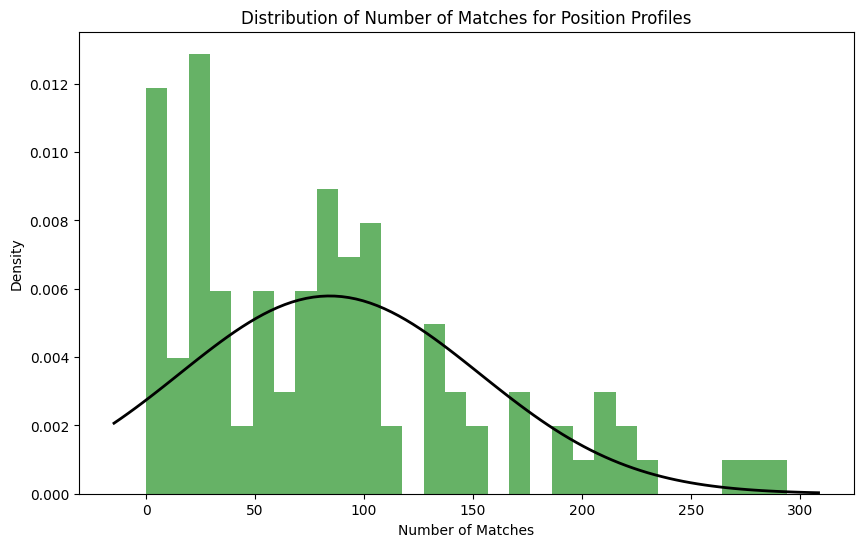

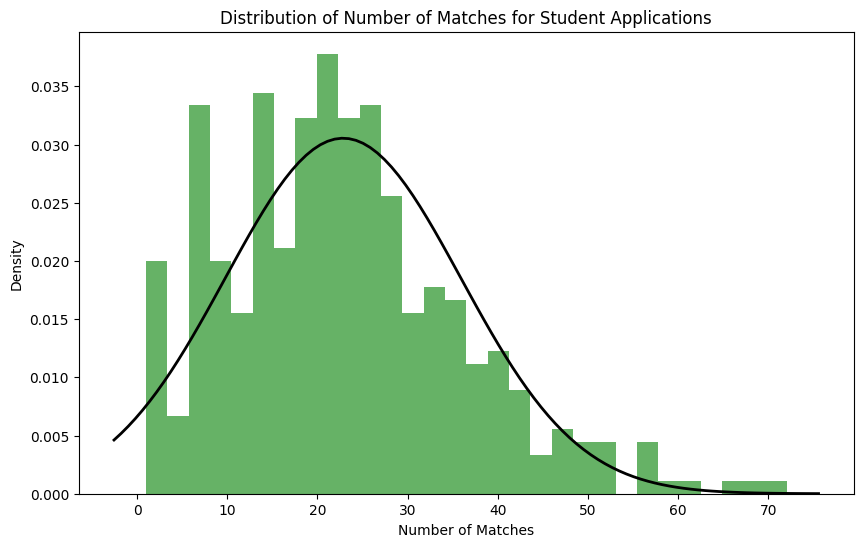

In [12]:
# The resulting histograms will show the distribution of the number of matches for position profiles and student applications.

# Extract the 'pos_Number of Matches' column
data = pos_num_matches['pos_Number of Matches']

# Plot the histogram of the data
plt.figure(figsize=(10, 6))
count, bins, ignored = plt.hist(data, bins=30, density=True, alpha=0.6, color='g')

# Fit a normal distribution to the data
mu, std = norm.fit(data)

# Plot the PDF of the fitted normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2)
title = 'Distribution of Number of Matches for Position Profiles'
plt.title(title)

plt.xlabel('Number of Matches')
plt.ylabel('Density')

plt.show()


# Extract the 'stu_Number of Matches' column
data = stu_num_matches['stu_Number of Matches']

# Plot the histogram of the data
plt.figure(figsize=(10, 6))
count, bins, ignored = plt.hist(data, bins=30, density=True, alpha=0.6, color='g')

# Fit a normal distribution to the data
mu, std = norm.fit(data)

# Plot the PDF of the fitted normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2)
title = 'Distribution of Number of Matches for Student Applications'
plt.title(title)

plt.xlabel('Number of Matches')
plt.ylabel('Density')

plt.show()

These plots show the distribution of the number of matches for position profiles and student applications. A few position profiles have a large number of matches, while most have fewer matches. The distribution for student applications is similar, with a few applications having a large number of matches and most having fewer matches. This causes the 'hard to match' comapnies issue where someone has to manually find matches for companies where the current system brings no matches. This can also result in less then optimal matches when one company has a large number of matches. It's difficult to sort through all the matches to find the best ones. The goal with the new pipelines is to flatten the distribution of matches so that there are fewer outliers and more evenly distributed matches.